### Introductions:
1. in a factory, there are **50 machines, each works 8 hours/day, 5 days/week**.
2. each machine fails after duration **between 100 and 150 hours**.
3. if spares are available,the failed machine will be sent to be repaired. If not, **20 dollars/hour/machine** to count loss of productivity.
4. repairer fixes failed machine in **4-10 hours**, repairer costs **3.75 dollars/hour**, after repairing, returns to spares.
5. purchase spares **30 dollars/day.**


*This can be applied to minimize the total cost of operating the factory including the cost of hiring workers,spare machines.*

In [267]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

In [268]:
# when the factory runs,generator starts,it launches all 50 of these machine tasks.
def factory_run(env,repairers,spares):
    global cost
    cost=0
    
    # launching 50 machines
    for i in range(50):
        env.process(operate_machine(env,repairers,spares))
        
    # managing the costs 
    while True:
        cost += 3.75*8*repairers.capacity + 30*spares.capacity # cost = repair cost + perchase spare cost
        yield env.timeout(8.0) # repeat every 8 hours

In [269]:
# operate machine: 1. wait for a certain duration   2. repair pricess  3. request a spare and add in costs
def operate_machine(env,repairers,spares):
    global cost
    
    while True:
        yield env.timeout(time_to_failure())
        t_broken = env.now # machine is broken, store this in a temporary variable t_broken is the current environment time.
       
        #launch repair process
        env.process(repair_machine(env,repairers,spares))
        yield spares.get(1)
        t_replaced = env.now # the machine is replaced, get a spare
        
        cost += 20*(t_replaced-t_broken) #If not, $20/hour/machine to count loss of productivity.

In [270]:
# repair machine
def repair_machine(env,repairers,spares):
    with repairers.request() as request:
        yield request
        yield env.timeout(generate_repair_time()) # wait for the repair to become available.
        yield spares.put(1) # after the repair process be completed, put the spare back in the spare pool.

In [271]:
def generate_time_to_failure():
    return np.random.uniform(100, 150) # waiting for the machine to break, it follows a uniform distribution between 100 and 150 hours.

In [272]:
def generate_repair_time():
    return np.random.uniform(4, 10)

In [273]:
observation_times = []
observation_cost = []
observation_spares = []

In [274]:
# observe the simulation.
def observe(env, spares):
    while True:
        observation_times.append(env.now)
        observation_cost.append(cost)
        observation_spares.append(spares.level)
        yield env.timeout(1.0) # happen every 1 hour.

In [275]:
# simpy environment and run the environment for a year
np.random.seed(0)
env = simpy.Environment()

# sharing resources
repairers = simpy.Resource(env,capacity = 3) # starting capacity = 3 repairers on staff
spares = simpy.Container(env, init=10, capacity=10) # initially there are 20 spares,total capacity for spares is also 20.

env.process(factory_run(env,repairers,spares))
env.process(observe(env, spares))
env.run(until=8*5*52) # 40 hours is not long enough for any failures to actually take place, so expand this from 40 hours for one work week to a year(52weeks).


Text(0, 0.5, 'Spares level')

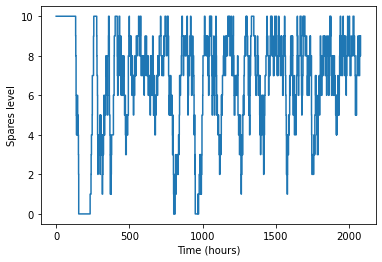

In [276]:
plt.figure()
plt.step(observation_times,observation_spares, where="post")
plt.xlabel("Time (hours)")
plt.ylabel("Spares level")

Text(0, 0.5, 'Cost Incurred')

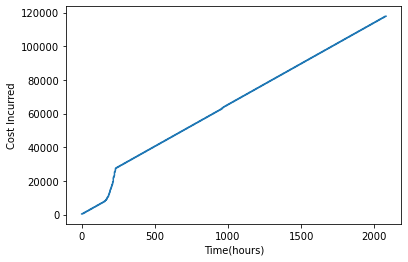

In [277]:
plt.figure()
plt.step(observation_times,observation_cost, where="post")
plt.xlabel("Time(hours)")
plt.ylabel("Cost Incurred")

In [281]:
print(observation_times[1])
print(observation_cost[-1])
print(observation_spares)

1.0
117777.97467016918
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 8, 8, 6, 5, 5, 4, 5, 5, 5, 4, 4, 6, 5, 5, 5, 5, 4, 4, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 3, 4, 4, 4, 4, 4, 5, 7, 7, 7, 7, 7, 7, 7, 7, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

1.The first failure for all 50 machines will happen between 100 and 150 hours. It will completely exhaust our spares and it will slowly replenish the machines as those spares become available.
2.In a longer term,it looks the failure time of these 50 machines get more distributed over time.